In [99]:
import pandas as pd
import re
import nltk
import random
import numpy as np
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Concatenate, Dropout, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize, sum
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc)
import seaborn as sns
import xgboost as xgb

In [100]:
SEED = 1
MODEL_IMG_FILENAME = 'output/lstm.png'
SERIALIZED_MODEL_FILENAME = 'output/lstm.weights.h5'
SERIALIZED_VECTORIZER_FILENAME = 'output/vectorizer.keras'
USE_PREPROCESSING = True

In [101]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/wojtek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wojtek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [102]:
resumes_job_postings = pd.read_csv('../../data/resumes_job_postings.csv')
resumes_job_postings.head()

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit


# Pre-processing

In [103]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

if USE_PREPROCESSING:
    resumes_job_postings['resume_text'] = resumes_job_postings['resume_text'].apply(clean_text)
    resumes_job_postings['job_description_text'] = resumes_job_postings['job_description_text'].apply(clean_text)

label_encoder = LabelEncoder()
resumes_job_postings['label'] = label_encoder.fit_transform(resumes_job_postings['label'])

X_train, X_test, y_train, y_test = train_test_split(
    resumes_job_postings[['resume_text', 'job_description_text']], resumes_job_postings['label'], test_size=0.2, random_state=SEED
)

max_len = 100
vectorizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=max_len)

vectorizer.adapt(pd.concat([X_train['resume_text'], X_train['job_description_text']]))

X_train_resume = vectorizer(X_train['resume_text'])
X_train_job_desc = vectorizer(X_train['job_description_text'])
X_test_resume = vectorizer(X_test['resume_text'])
X_test_job_desc = vectorizer(X_test['job_description_text'])

X_train_combined = np.hstack([X_train_resume, X_train_job_desc])
X_test_combined = np.hstack([X_test_resume, X_test_job_desc])

# Random forrest

In [104]:
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(X_train_combined, y_train)
rf_y_pred = rf_model.predict(X_test_combined)
rf_accuracy = accuracy_score(y_test, rf_y_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.6656


# Logistic regression

In [105]:
lr_model = LogisticRegression(random_state=SEED)
lr_model.fit(X_train_combined, y_train)
lr_y_pred = lr_model.predict(X_test_combined)
lr_accuracy = accuracy_score(y_test, lr_y_pred)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.5238


/home/wojtek/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# SVM

In [106]:
svm_model = SVC(random_state=SEED)
svm_model.fit(X_train_combined, y_train)
svm_y_pred = svm_model.predict(X_test_combined)
svm_accuracy = accuracy_score(y_test, svm_y_pred)

print(f"SVM Accuracy: {svm_accuracy:.4f}")

SVM Accuracy: 0.5975


# Neural Networks (MLP)

In [107]:
mlp_model = MLPClassifier(random_state=SEED)
mlp_model.fit(X_train_combined, y_train)
mlp_y_pred = mlp_model.predict(X_test_combined)
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)

print(f"MLP Accuracy: {mlp_accuracy:.4f}")

MLP Accuracy: 0.5269


# XGBoost

In [108]:
xgb_model = xgb.XGBClassifier(random_state=SEED)
xgb_model.fit(X_train_combined, y_train)
xgb_y_pred = xgb_model.predict(X_test_combined)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)

print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.6913


# LSTM based Neural Network

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [8, 16],
    'dropout_rate': [0.3, 0.4],
    'lstm_units': [64, 128],
    'epochs': [10, 15],
    'embedding_dim': [64, 128]
}

best_model = None
best_params = None
best_test_accuracy = 0
best_history = None

results = []

combinations = ParameterGrid(param_grid)

total_combinations = len(combinations)
completed_combinations = 0

print(f"Starting grid search over {total_combinations} combinations...")

for params in combinations:
    learning_rate = params.pop('learning_rate')
    batch_size = params.pop('batch_size')
    dropout_rate = params.pop('dropout_rate')
    lstm_units = params.pop('lstm_units')
    epochs = params.pop('epochs')
    embedding_dim = params.pop('embedding_dim')

    input_resume = Input(shape=(max_len,))
    input_job_desc = Input(shape=(max_len,))

    embedding = Embedding(input_dim=10000, output_dim=embedding_dim)

    encoded_resume = embedding(input_resume)
    encoded_job_desc = embedding(input_job_desc)

    shared_lstm = LSTM(lstm_units, return_sequences=True)

    lstm_resume = shared_lstm(encoded_resume)
    lstm_job_desc = shared_lstm(encoded_job_desc)

    resume_pooling = Lambda(lambda x: sum(x, axis=1), output_shape=(lstm_units,))(lstm_resume)
    job_desc_pooling = Lambda(lambda x: sum(x, axis=1), output_shape=(lstm_units,))(lstm_job_desc)

    normalized_resume = Lambda(lambda x: l2_normalize(x, axis=1), output_shape=(lstm_units,))(resume_pooling)
    normalized_job_desc = Lambda(lambda x: l2_normalize(x, axis=1), output_shape=(lstm_units,))(job_desc_pooling)

    cosine_similarity = Lambda(lambda x: sum(x[0] * x[1], axis=1, keepdims=True), output_shape=(1,))([normalized_resume, normalized_job_desc])

    merged = Concatenate()([normalized_resume, normalized_job_desc, cosine_similarity])
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(dropout)

    model = Model(inputs=[input_resume, input_job_desc], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit([X_train_resume, X_train_job_desc], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    test_loss, test_accuracy = model.evaluate([X_test_resume, X_test_job_desc], y_test, verbose=0)

    results.append({
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'lstm_units': lstm_units,
        'epochs': epochs,
        'embedding_dim': embedding_dim,
        'train_loss': history.history['loss'][-1],
        'test_loss': test_loss,
        'train_accuracy': history.history['accuracy'][-1],
        'test_accuracy': test_accuracy
    })

    if test_accuracy > best_test_accuracy:
        best_model = model
        best_params = params
        best_test_accuracy = test_accuracy
        best_history = history

    completed_combinations += 1
    print(f"Completed {completed_combinations}/{total_combinations} combinations...")
    print(f"Parameters: {str(results[-1])}")
    print(f"Current Test Accuracy: {test_accuracy:.4f}")
    print(f"Current Best Test Accuracy: {best_test_accuracy:.4f}")

In [110]:
print("Results for all combinations:")
print(pd.DataFrame(results).sort_values(by="test_accuracy", ascending=False).to_string(index=False))

Results for all combinations:
 learning_rate  batch_size  dropout_rate  lstm_units  epochs  embedding_dim  train_loss  test_loss  train_accuracy  test_accuracy
         0.001           8           0.4          64      15            128    0.155867   0.619650        0.966992       0.833750
         0.001           8           0.3          64      10            128    0.220385   0.581420        0.947070       0.827500
         0.001           8           0.3          64      15             64    0.175469   0.673524        0.960938       0.821250
         0.001          16           0.3         128      10            128    0.261366   0.568487        0.933984       0.819375
         0.001           8           0.3          64      10             64    0.227995   0.603421        0.943164       0.818125
         0.001           8           0.4         128      15             64    0.183357   0.680326        0.957617       0.814375
         0.001          16           0.4          64      15

In [111]:
print(f'Accuracy: {best_test_accuracy:.4f}')

y_pred_probs = best_model.predict([X_test_resume, X_test_job_desc])
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_679', 'keras_tensor_680']. Received: the structure of inputs=('*', '*')
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
               precision    recall  f1-score   support

     Good Fit       0.78      0.83      0.81       397
       No Fit       0.89      0.89      0.89       805
Potential Fit       0.78      0.72      0.75       398

     accuracy                           0.83      1600
    macro avg       0.82      0.81      0.81      1600
 weighted avg       0.83      0.83      0.83      1600



# LSTM accuracy per epoch

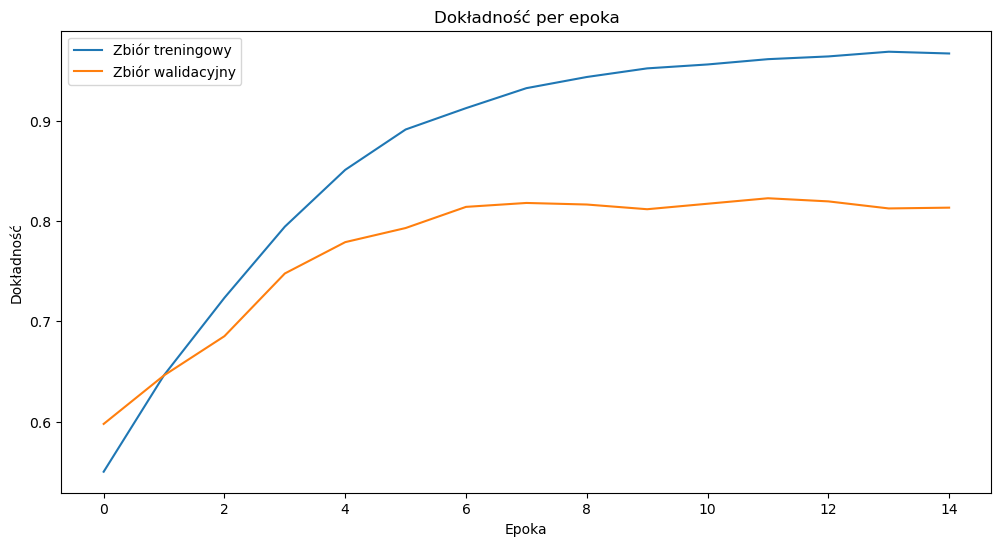

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['accuracy'], label='Zbiór treningowy')
plt.plot(best_history.history['val_accuracy'], label='Zbiór walidacyjny')
plt.title('Dokładność per epoka')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

# LSTM loss per epoch

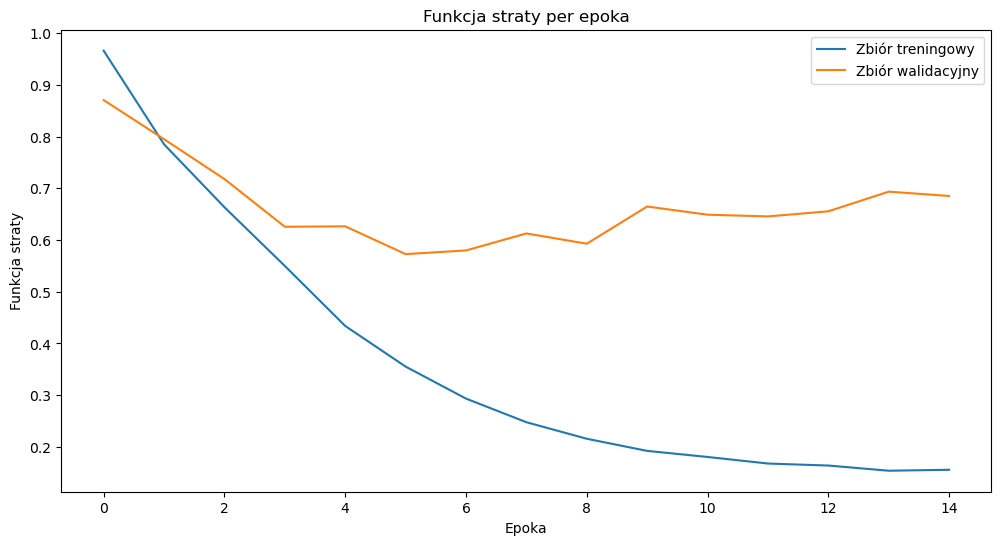

In [113]:
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['loss'], label='Zbiór treningowy')
plt.plot(best_history.history['val_loss'], label='Zbiór walidacyjny')
plt.title('Funkcja straty per epoka')
plt.xlabel('Epoka')
plt.ylabel('Funkcja straty')
plt.legend()
plt.show()

# Confusion matrix

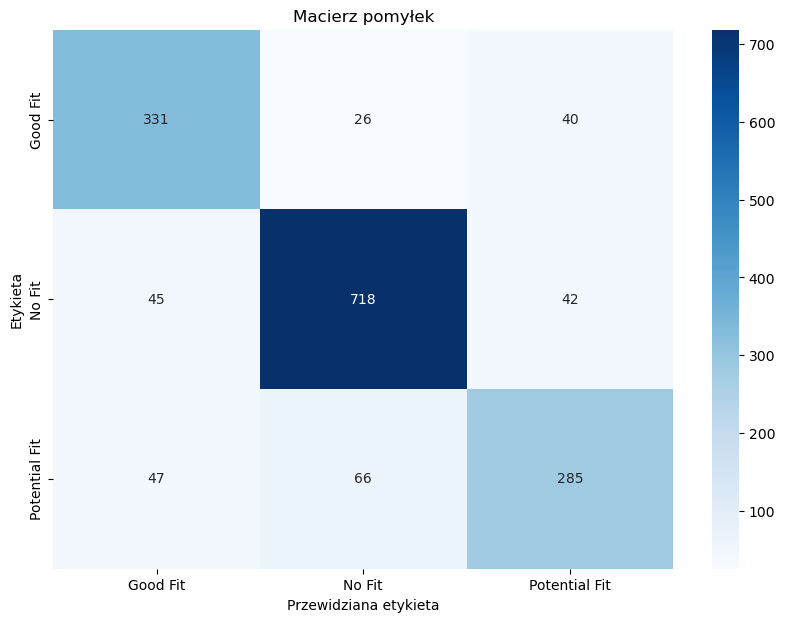

In [114]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana etykieta')
plt.ylabel('Etykieta')
plt.show()

# LSTM Gini and ROC

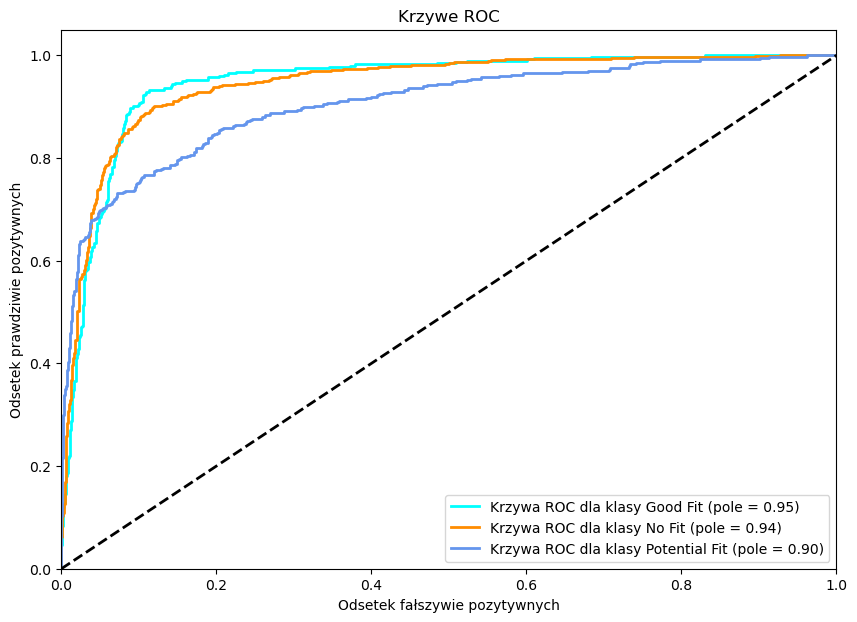

Gini: 0.8650622279681996


In [115]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(label_encoder.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Krzywa ROC dla klasy {label_encoder.classes_[i]} (pole = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Krzywe ROC')
plt.legend(loc="lower right")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
gini = 2 * roc_auc - 1
print(f'Gini: {gini}')

# Plot model

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_92      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_93      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45        │ (None, 100, 128)  │  1,280,000 │ input_layer_92[0… │
│ (Embedding)         │                   │            │ input_layer_93[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 100, 64)   │     49,408 │ embedding_45[0][… │
│                     │                   │            │ embedding_45[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_225 (Lambda) │ (None, 64)        │          0 │ lstm_45[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_226 (Lambda) │ (None, 64)        │          0 │ lstm_45[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_227 (Lambda) │ (None, 64)        │          0 │ lambda_225[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_228 (Lambda) │ (None, 64)        │          0 │ lambda_226[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_229 (Lambda) │ (None, 1)         │          0 │ lambda_227[0][0], │
│                     │                   │            │ lambda_228[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_45      │ (None, 129)       │          0 │ lambda_227[0][0], │
│ (Concatenate)       │                   │            │ lambda_228[0][0], │
│                     │                   │            │ lambda_229[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 64)        │      8,320 │ concatenate_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 64)        │          0 │ dense_90[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 3)         │        195 │ dropout_45[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,013,771 (15.31 MB)

 Trainable params: 1,337,923 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,675,848 (10.21 MB)

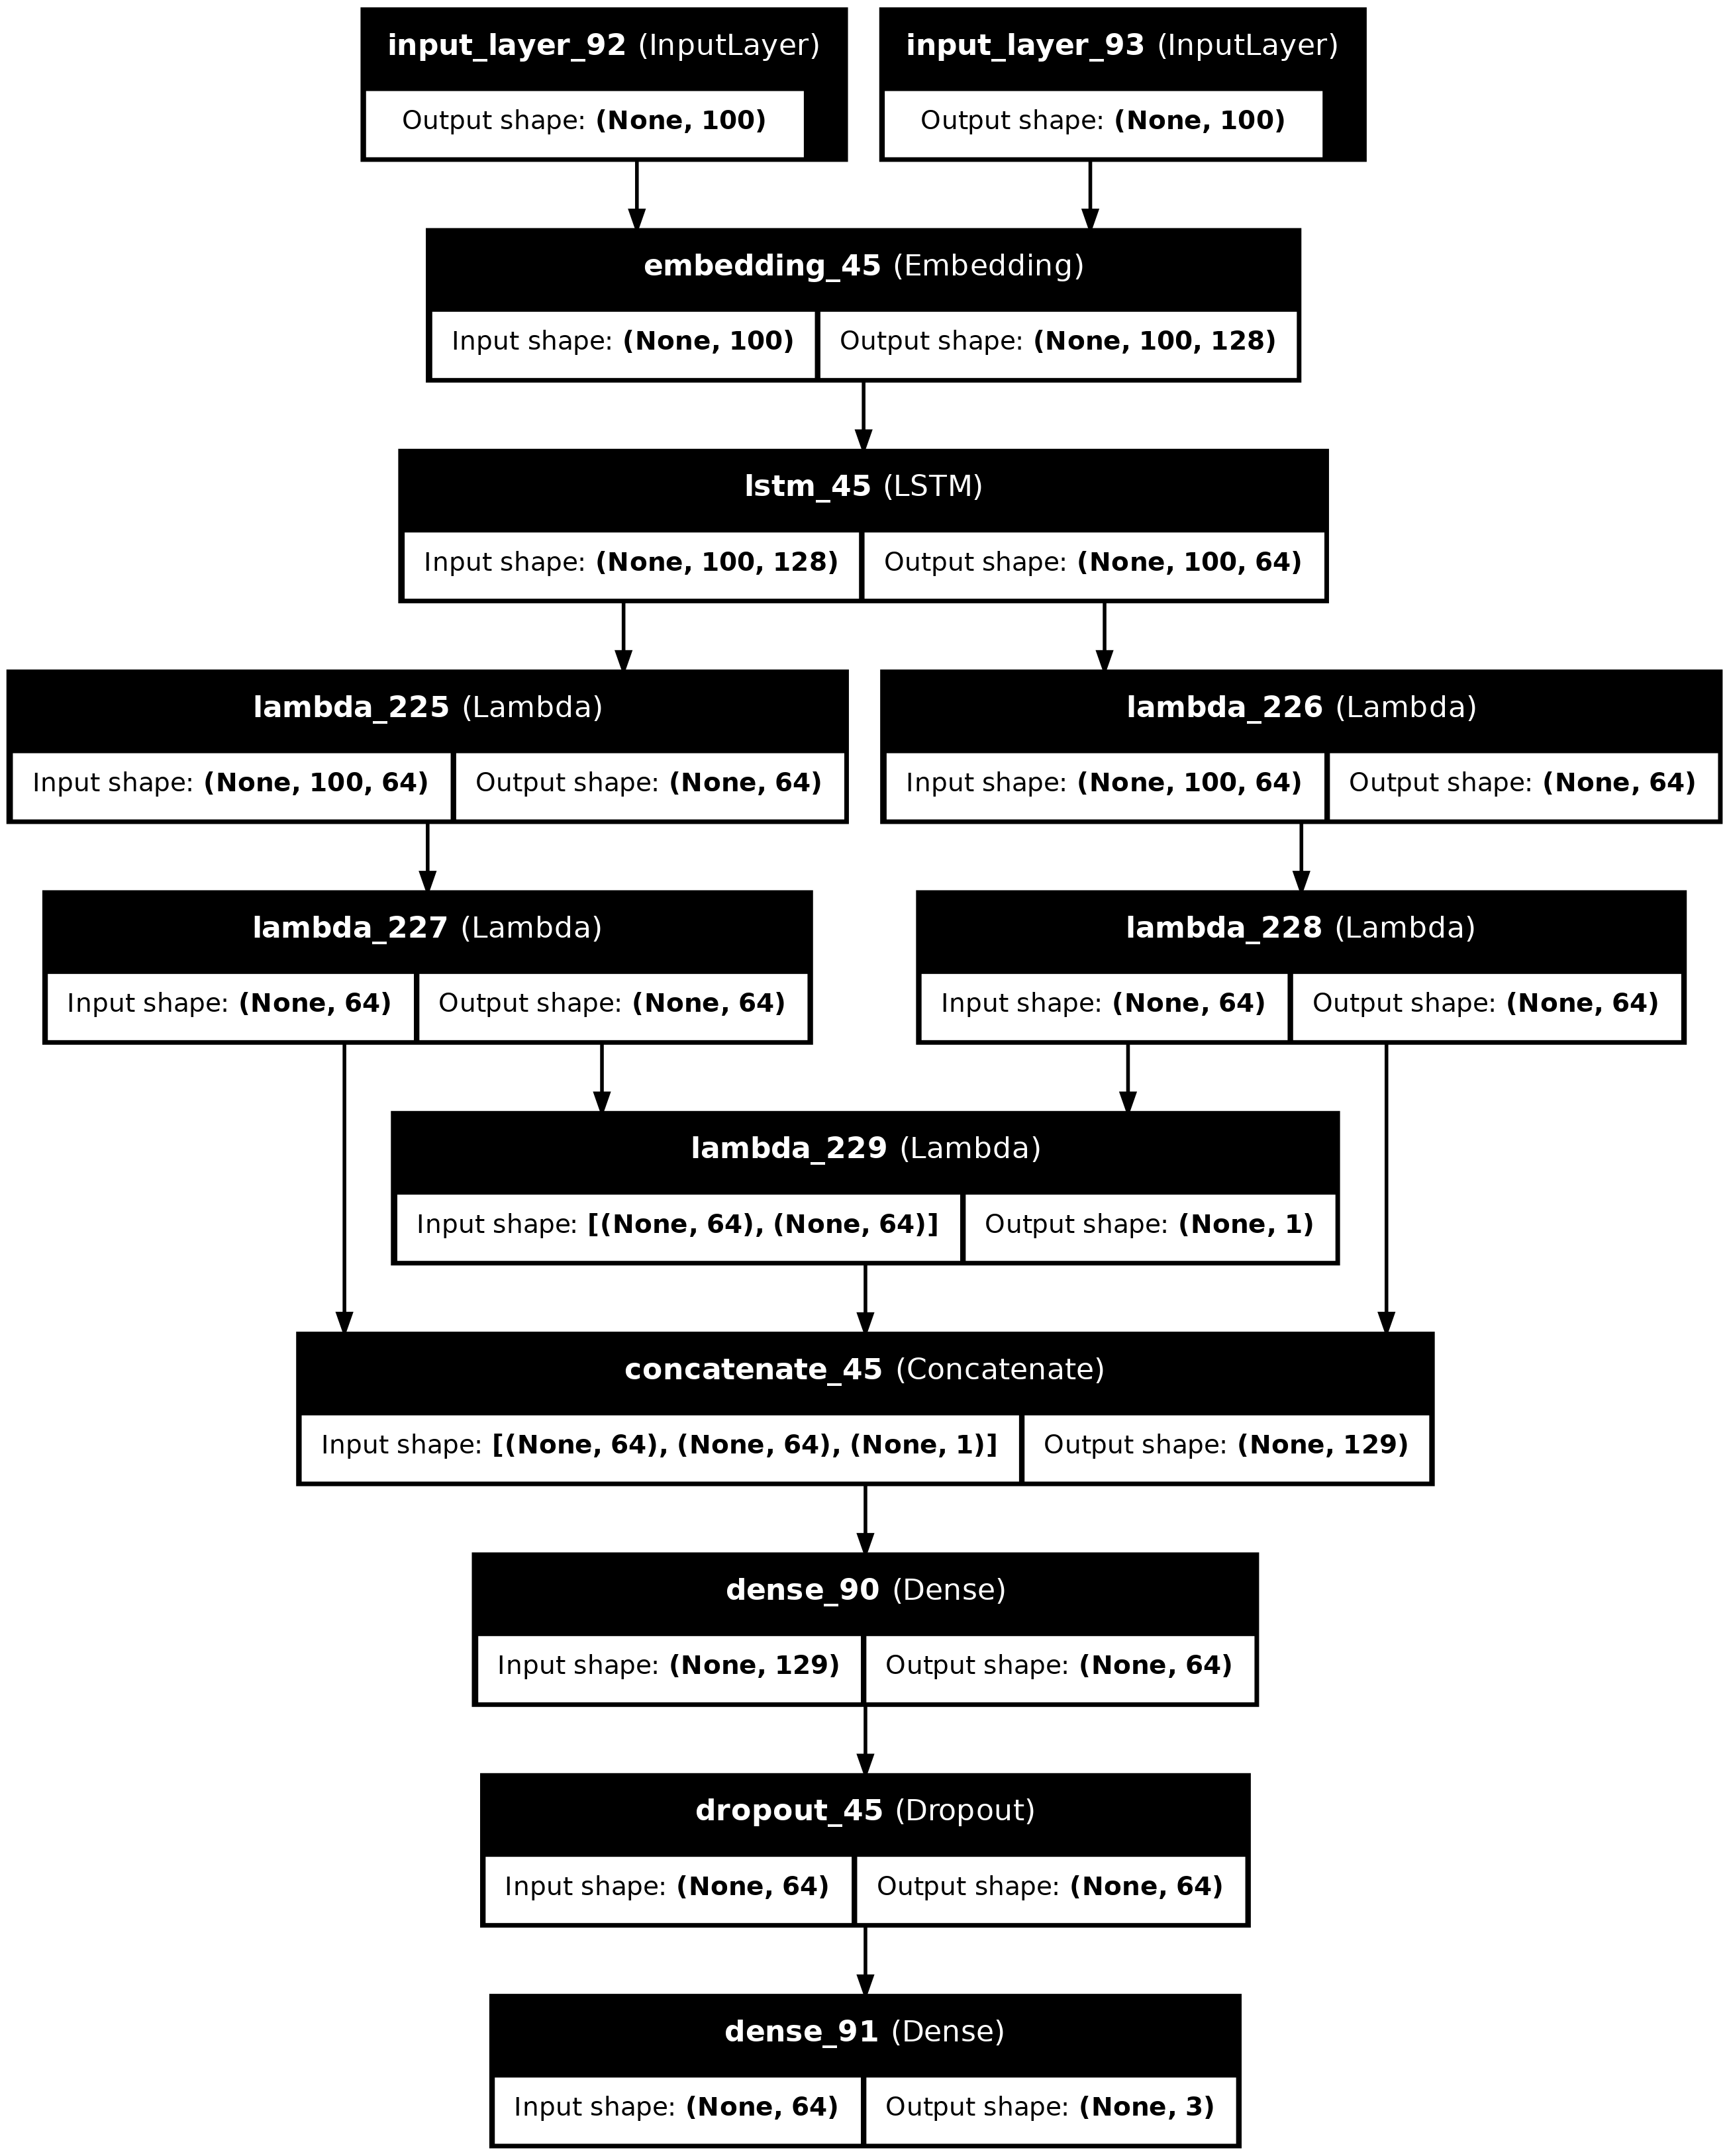

In [116]:
best_model.summary()

plot_model(best_model, to_file=MODEL_IMG_FILENAME, show_shapes=True, show_layer_names=True)

# Save model and vectorizer

In [117]:
best_model.save_weights(SERIALIZED_MODEL_FILENAME)

input_text = tf.keras.Input(shape=(1,), dtype=tf.string)
vectorized_text = vectorizer(input_text)
vectorizer_model = Model(inputs=input_text, outputs=vectorized_text)
vectorizer_model.save(SERIALIZED_VECTORIZER_FILENAME)